In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

In [12]:
# Function to get the DCT of the sub-images/blocks
def dct2D(img):
    tmp = dct(img, type=2 ,norm='ortho').transpose()
    return dct(tmp, type=2 ,norm='ortho').transpose()

# Function to get the zig-zag scan of the quantized DCT coefficients
def zigzagScan(img):
    hmin = 0
    wmin = 0
    hmax = img.shape[0] - 1
    wmax = img.shape[1] - 1
    h = hmin
    w = wmin
    scan = np.zeros((img.shape[0] * img.shape[1]), dtype=np.int16)
    i = 0
    while h <= hmax and w <= wmax:
        # print(h, w)
        # Going up
        if (h + w) % 2 == 0:
            # Last column
            if w == wmax:
                scan[i] = img[h, w]
                h += 1
                i += 1
            # First row
            elif h == hmin:
                scan[i] = img[h, w]
                w += 1
                i += 1
            # Other cases
            else:
                scan[i] = img[h, w]
                h -= 1
                w += 1
                i += 1
        # Going down
        else:
            # Last row
            if h == hmax:
                scan[i] = img[h, w]
                w += 1
                i += 1
            # First column
            elif w == wmin:
                scan[i] = img[h, w]
                h += 1
                i += 1
            # Other cases
            else:
                scan[i] = img[h, w]
                h += 1
                w -= 1
                i += 1
    return scan

# Function to get the quantization matrix according to the block size
def quantizationMatrix(blockSize, flag=0):
    # Defining the standard quantization matrix for JPEG compression
    Q1 = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]])
    Q2 = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
            [18, 21, 26, 66, 99, 99, 99, 99],
            [24, 26, 56, 99, 99, 99, 99, 99],
            [47, 66, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99],
            [99, 99, 99, 99, 99, 99, 99, 99]])
    if blockSize == [8, 8]:
        if flag == 0:
            return Q1
        if flag == 1:
            return Q2
    else:
        Q1 = np.resize(Q1, (blockSize[0], blockSize[1]))
        Q2 = np.resize(Q2, (blockSize[0], blockSize[1]))
        if flag == 0:
            return Q1
        if flag == 1:
            return Q2

In [13]:
# Function to get the inverse DCT
def idct2D(dctImg):
    tmp = idct(dctImg, type=2 ,norm='ortho').transpose()
    return idct(tmp, type=2 ,norm='ortho').transpose()

# Function to get the inverse zig-zag scan of the quantized DCT coefficients
def inverseZigzagScan(scan):
    img = np.zeros((8, 8), dtype=np.int16)
    hmin = 0
    wmin = 0
    hmax = 7
    wmax = 7
    h = hmin
    w = wmin
    i = 0
    while h <= hmax and w <= wmax:
        # Going up
        if (h + w) % 2 == 0:
            # Last column
            if w == wmax:
                img[h, w] = scan[i]
                h += 1
                i += 1
            # First row
            elif h == hmin:
                img[h, w] = scan[i]
                w += 1
                i += 1
            # Other cases
            else:
                img[h, w] = scan[i]
                h -= 1
                w += 1
                i += 1
        # Going down
        else:
            # Last row
            if h == hmax:
                img[h, w] = scan[i]
                w += 1
                i += 1
            # First column
            elif w == wmin:
                img[h, w] = scan[i]
                h += 1
                i += 1
            # Other cases
            else:
                img[h, w] = scan[i]
                h += 1
                w -= 1
                i += 1
    return img

In [14]:
def jpeg_encode(img, blockSize, numberOfCoefficients, flag=0):
    h, w = img.shape
    
    # Size of each block
    a, b = blockSize
    size = a * b

    # Dividing the image into sub-images/blocks
    subImages = np.zeros((h//a, w//b, a, b), dtype=np.int16)
    for i in range(0, h, a):
        for j in range(0, w, b):
            subImages[i//a][j//b] = (img[i:i+a, j:j+b])

    # Subtracting 128 from each value in the sub-images
    subImages -= 128 

    # Applying DCT to each 8x8 block
    dctImages = np.zeros((h//a, w//b, a, b), dtype=np.float16)
    for i in range(h//a):
        for j in range(w//b):
            dctImages[i][j] = dct2D(subImages[i][j])

    # Defining the standard quantization matrix for JPEG compression
    Q = quantizationMatrix(blockSize, flag)

    # Quantizing the DCT coefficients
    quantized = np.zeros((h//a, w//b, a, b), dtype=np.int16)
    for i in range(h//a):
        for j in range(w//b):
            quantized[i][j] = np.round(dctImages[i][j]/Q)

    # Zigzag scanning
    zigzag = np.zeros((h//a, w//b, size), dtype=np.int16)
    for i in range(h//a):
        for j in range(w//b):
            zigzag[i][j] = zigzagScan(quantized[i][j])

    # Obtaining the final JPEG encoded integer array
    jpegCompressed = []
    for i in range(h//a):
        for j in range(w//b):
            if numberOfCoefficients == 0:
                k = 63
                while k >= 0 and zigzag[i][j][k] == 0:
                    k -= 1
                k += 1
                for l in range(k):
                    jpegCompressed.append(zigzag[i][j][l])
            else:
                for k in range(numberOfCoefficients):
                    jpegCompressed.append(zigzag[i][j][k])
    
    return jpegCompressed

In [15]:
def jpeg_decode(img, blockSize, numberOfCoefficients, jpegCompressed, flag=0):
    # Height and width of the image
    h, w = img.shape
    
    # Size of each block
    a, b = blockSize
    size = a * b

    # Getting the quantized DCT coefficients by reversing the zigzag scan
    scan = np.zeros(size, dtype=np.int16)
    inverseZigzag = np.zeros((h//a, w//b, a, b), dtype=np.int16)
    for i in range(h//a):
        for j in range(w//b):
            for k in range(size):
                if k < numberOfCoefficients:
                    scan[k] = jpegCompressed[(i * w//b + j) * numberOfCoefficients + k]
                else:
                    scan[k] = 0
            inverseZigzag[i][j] = inverseZigzagScan(scan)

    # Dequantizing the DCT coefficients
    Q = quantizationMatrix(blockSize, flag)
    inverseQuantized = inverseZigzag * Q

    # Applying the inverse DCT to each 8x8 block
    inverseDCT = np.zeros((h//a, w//b, a, b), dtype=np.float16)
    for i in range(h//a):
        for j in range(w//b):
            inverseDCT[i][j] = idct2D(inverseQuantized[i][j])

    # Adding 128 to each pixel
    inverseDCT += 128

    decodedImg = np.zeros((h, w), dtype=np.uint8)
    for i in range(h//a):
        for j in range(w//b):
            decodedImg[i*a:(i+1)*a, j*b:(j+1)*b] = inverseDCT[i][j].astype(np.uint8)
    return decodedImg

In [16]:
def jpeg(filename, blockSize, numberOfCoefficients, color):
    img = cv.imread(filename, color)
    # JPEG Encoding
    # Gray-scale images
    if color == 0:
        jpegEncodedArray = jpeg_encode(img, blockSize, numberOfCoefficients)
    # RGB images
    if color == 1:
        img = cv.cvtColor(img, cv.COLOR_BGR2YCrCb)
        jpeg1 = jpeg_encode(img[:,:,0], blockSize, numberOfCoefficients, 0)
        jpeg2 = jpeg_encode(img[:,:,1], blockSize, numberOfCoefficients, 1)
        jpeg3 = jpeg_encode(img[:,:,2], blockSize, numberOfCoefficients, 1)
        jpegEncodedArray = np.concatenate((jpeg1, jpeg2, jpeg3))
    
    jpegCompressed = jpegEncodedArray

    # JPEG Decoding
    # Gray-scale images
    if color == 0:
        img = cv.imread(filename, 0)
        decodedImg = jpeg_decode(img, blockSize, numberOfCoefficients, jpegCompressed, 0)
    # RGB images
    if color == 1:
        img = cv.imread(filename, 1)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.cvtColor(img, cv.COLOR_RGB2YCR_CB)
        x = len(jpegCompressed)//3
        jpeg1 = jpegCompressed[:x]
        jpeg2 = jpegCompressed[x:2*x]
        jpeg3 = jpegCompressed[2*x:3*x]
        decodedY = jpeg_decode(img[:,:,0], blockSize, numberOfCoefficients, jpeg1, 0)
        decodedCr = jpeg_decode(img[:,:,1], blockSize, numberOfCoefficients, jpeg2, 1)
        decodedCb = jpeg_decode(img[:,:,2], blockSize, numberOfCoefficients, jpeg3, 1)
        decodedImg = np.dstack((decodedY, decodedCr, decodedCb))
        decodedImg = cv.cvtColor(decodedImg, cv.COLOR_YCR_CB2RGB)
        img = cv.cvtColor(img, cv.COLOR_YCR_CB2RGB)

    # Calculating the RMSE, PSNR and Compression Ratio
    RMSE = np.sqrt(np.mean((img - decodedImg) ** 2))
    PSNR = 20 * np.log10(255.0 / RMSE)
    compRatio = (img.size * 8) / (len(jpegCompressed) * 8)
    return img, decodedImg, RMSE, PSNR, compRatio


In [17]:
# Analysis
def analysis(filename,color=0):
    img, decodedImg = jpeg(filename, (8, 8), 10, color)[:2]
    plt.figure(figsize=(10, 10))
    if color == 0:
        plt.subplot(121); plt.imshow(img, cmap = 'gray'); plt.title('Original Image'); plt.axis('off')
        plt.subplot(122); plt.imshow(decodedImg, cmap = 'gray'); plt.title('Decoded Image'); plt.axis('off')
    if color == 1:
        plt.subplot(121); plt.imshow(img); plt.title('Original Image'); plt.axis('off')
        plt.subplot(122); plt.imshow(decodedImg); plt.title('Decoded Image'); plt.axis('off')

    PSNR = []
    RMSE = []
    compRatio = []
    data = []
    n = [1, 3, 6, 10, 15, 21, 28]
    for i in n:
        r, p, c = jpeg(filename, (8, 8), i, color)[2:]
        RMSE.append(r)
        PSNR.append(p)
        compRatio.append(c)
        data.append([i, p, r, c])

    plt.rcParams["figure.figsize"] = [10, 5]
    plt.rcParams["figure.autolayout"] = True
    fig, axs = plt.subplots(1, 1)
    columns = ("Number of coefficients sent", "PSNR", "RMSE", "Compression Ratio")
    axs.axis('tight')
    axs.axis('off')
    the_table = axs.table(cellText=data, colLabels=columns, loc='center')
    plt.show()

    xPoints = []
    yPoints = []
    for i in range(len(data)):
        xPoints.append(data[i][0])
        yPoints.append(data[i][1])
    plt.plot(xPoints, yPoints)
    plt.xlabel("Number of coefficients sent")
    plt.ylabel("PSNR")
    plt.show()

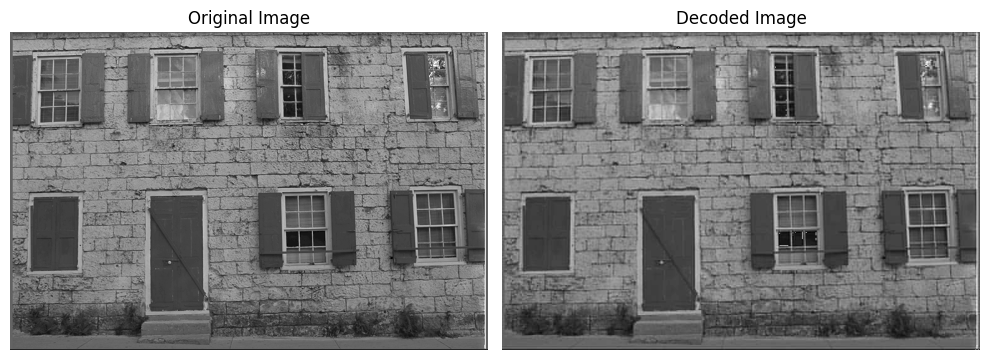

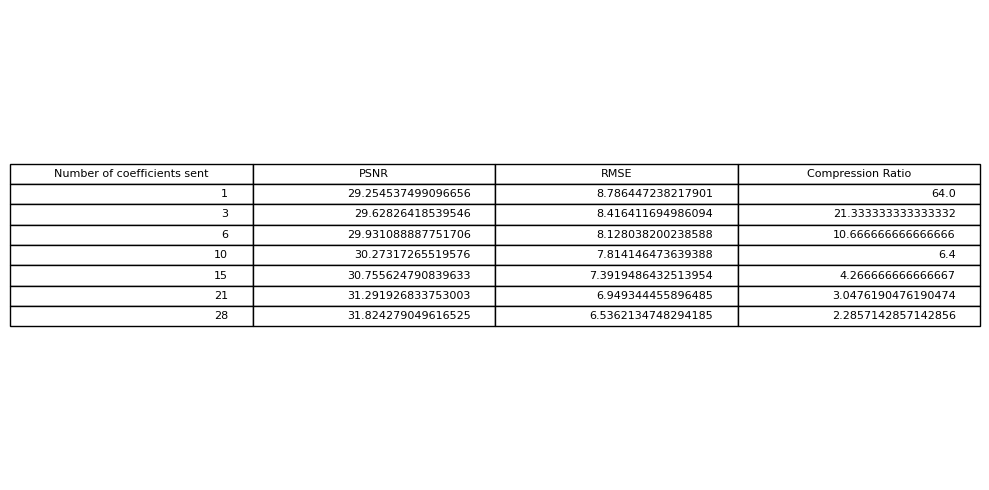

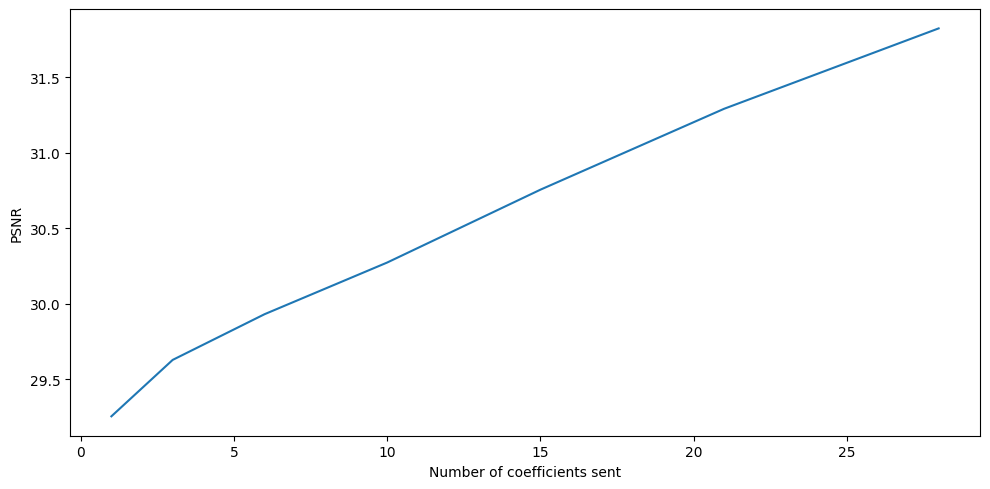

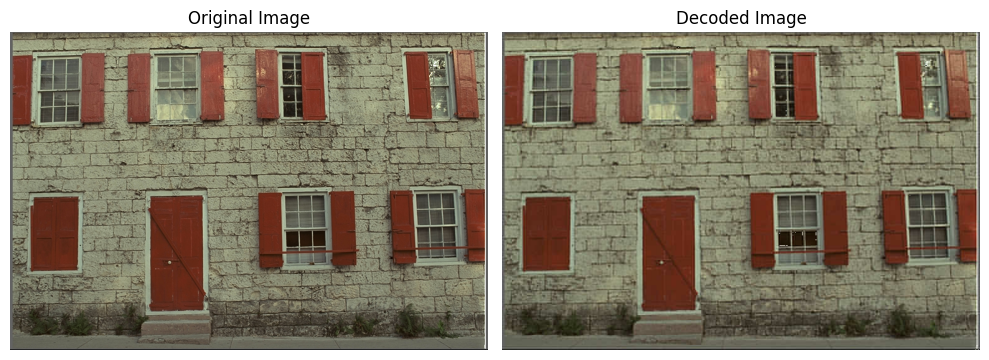

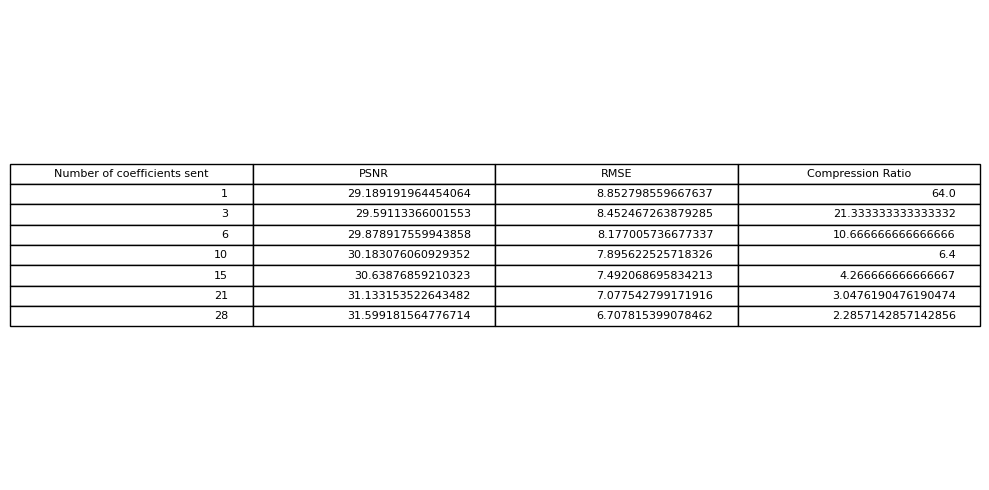

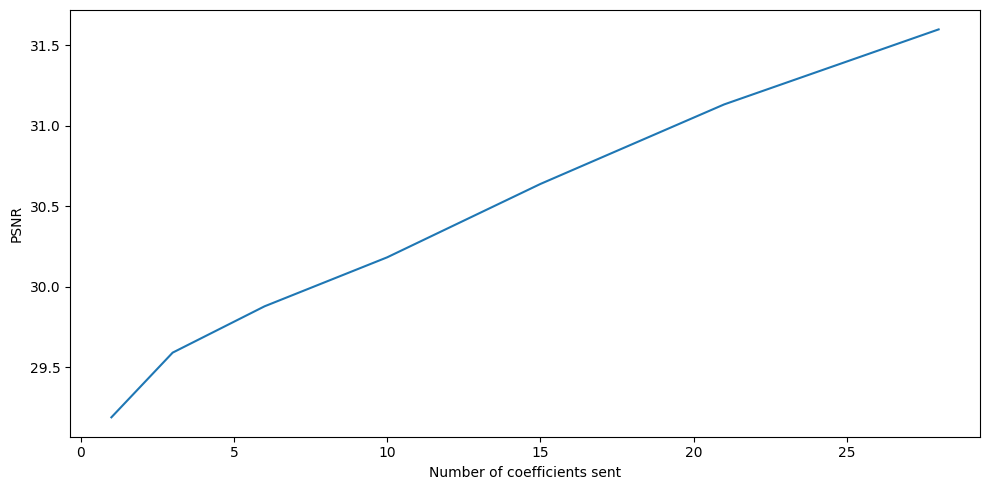

In [18]:
analysis("test/kodim01.png")
analysis("test/kodim01.png", 1)

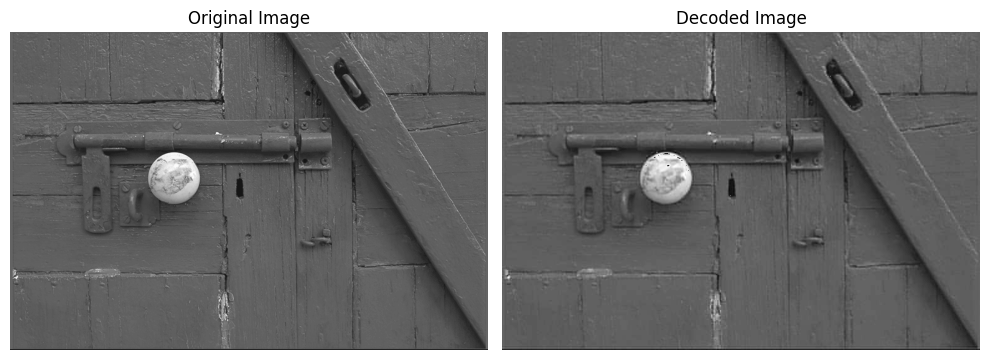

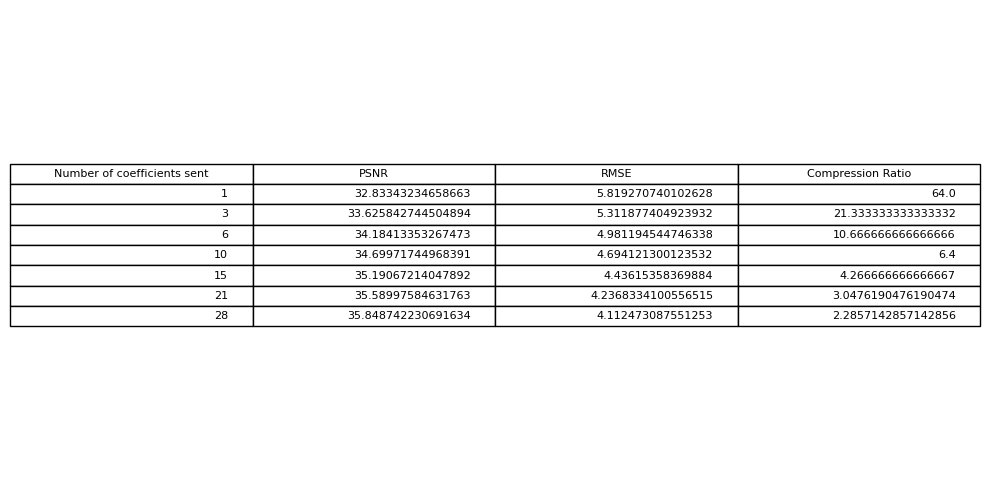

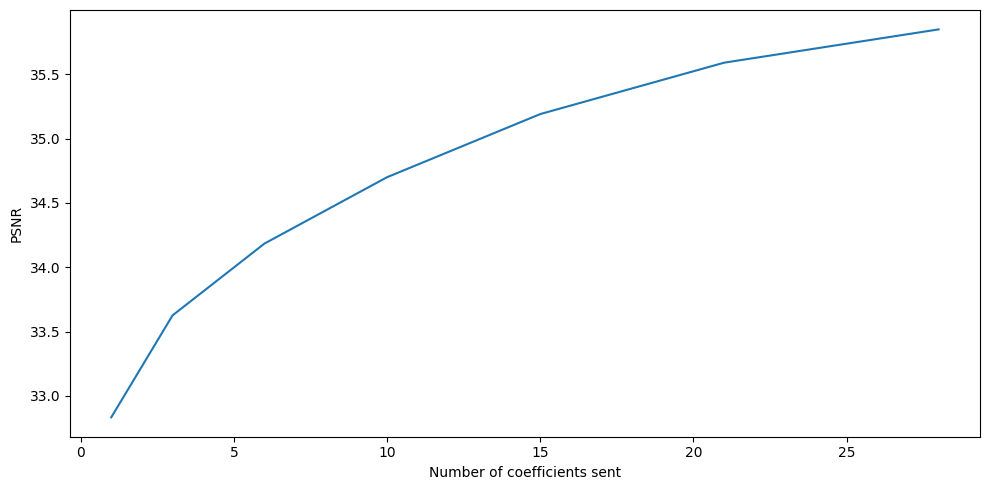

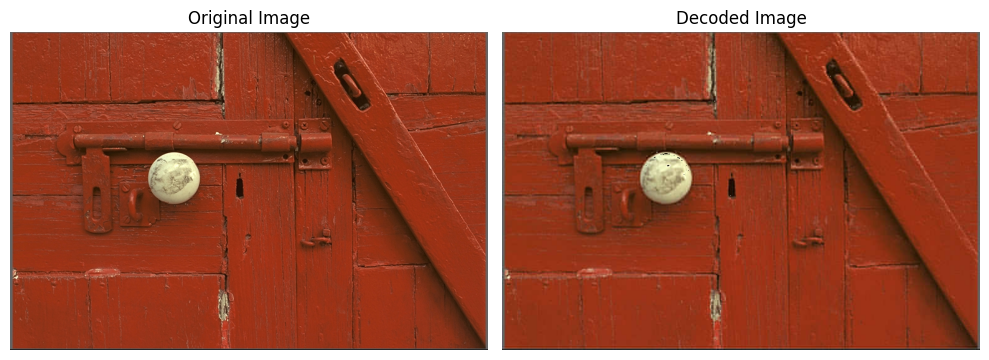

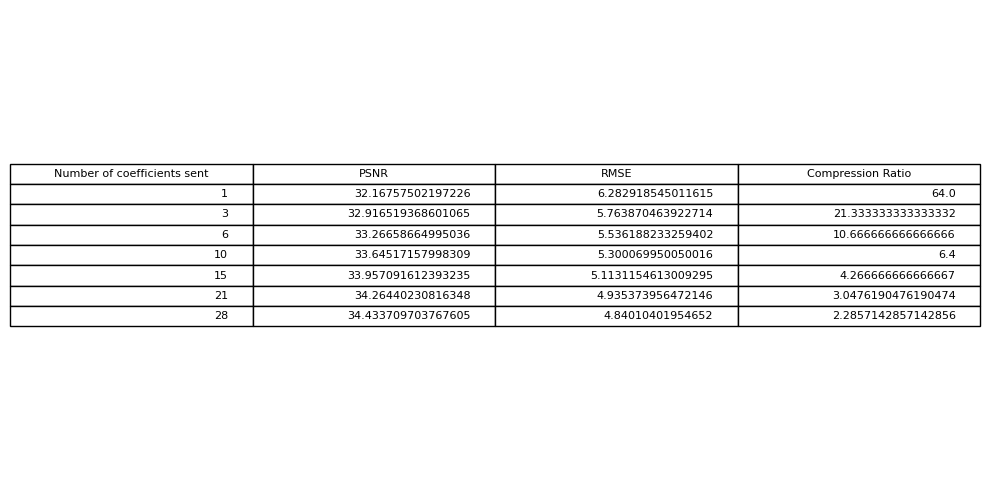

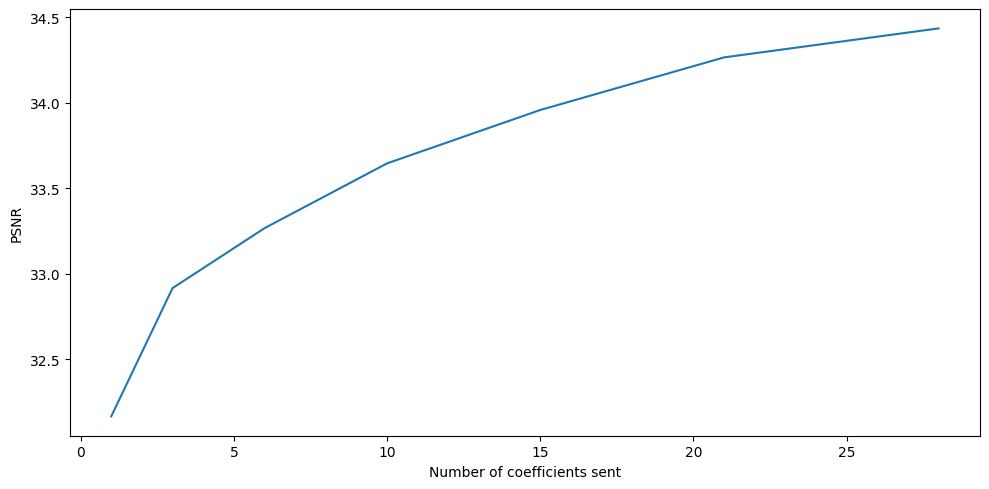

In [19]:
analysis("test/kodim02.png")
analysis("test/kodim02.png", 1)

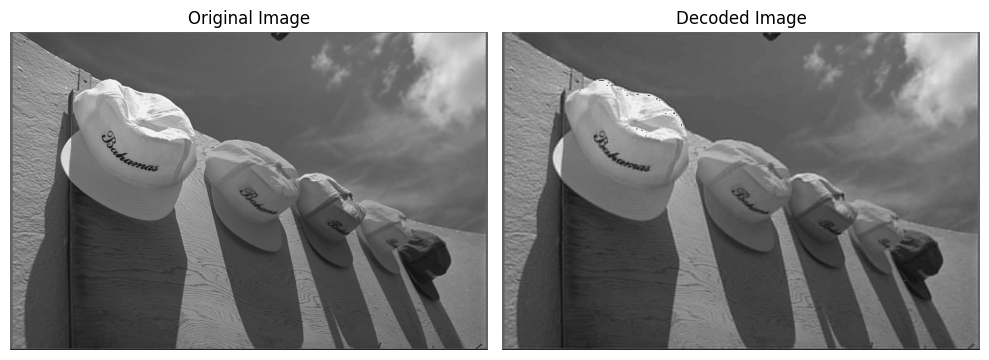

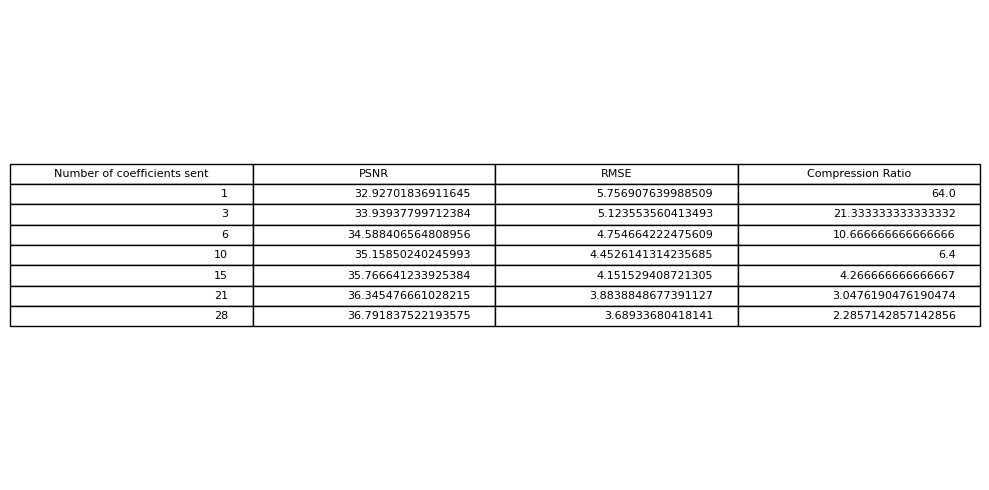

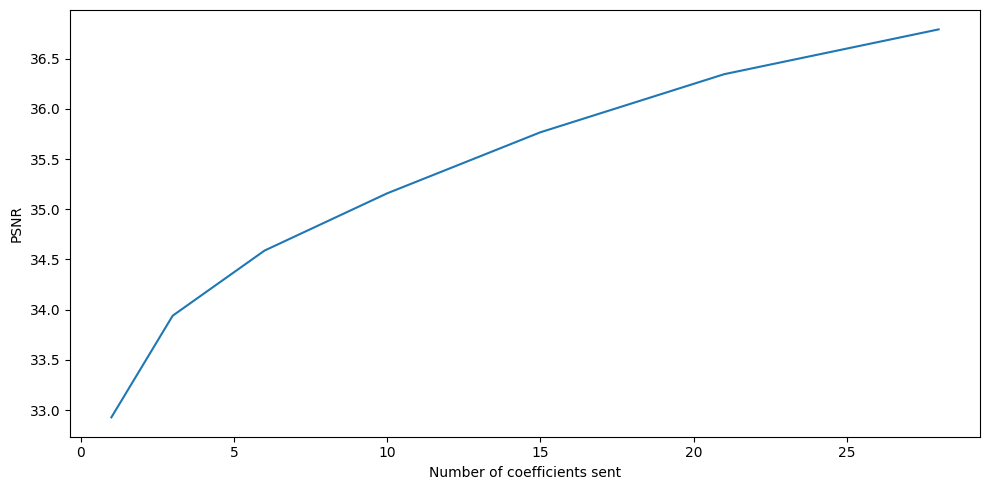

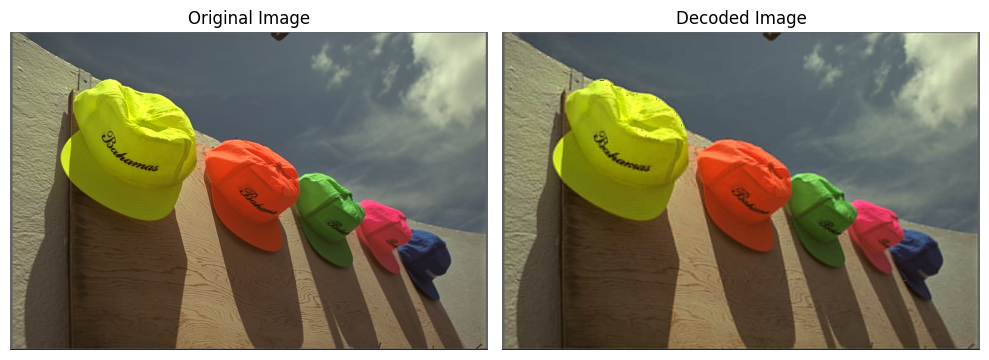

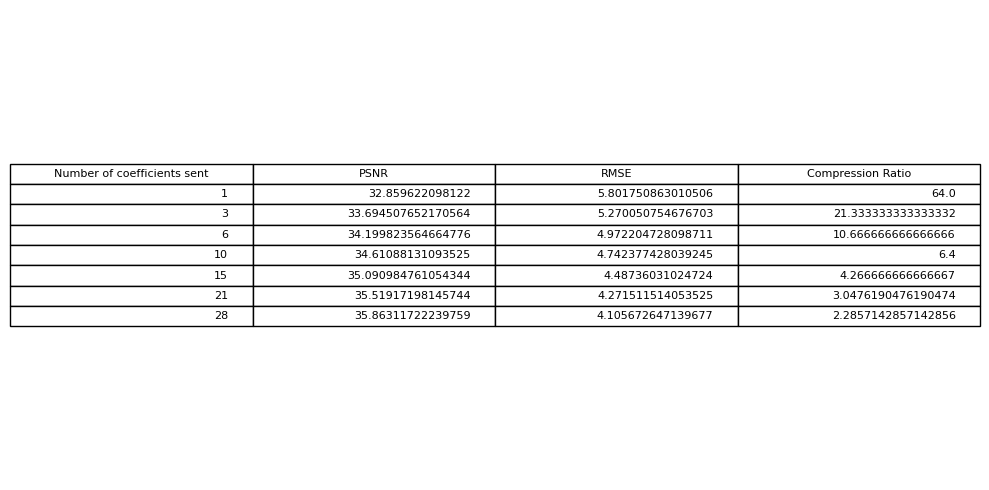

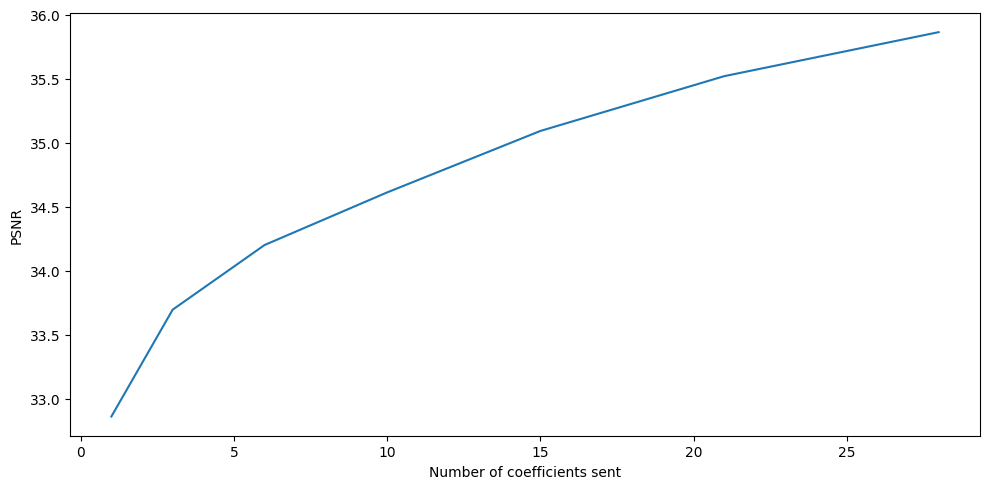

In [20]:
analysis("test/kodim03.png")
analysis("test/kodim03.png", 1)